In [69]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [70]:
df = pdr.get_data_tiingo('AAPL', api_key='4996aec7b63ece86f915371f042f4990eb9c9c89')

In [71]:
df.head()

close      high      low    open  \
symbol date                                                           
AAPL   2015-07-31 00:00:00+00:00  121.30  122.6425  120.910  122.60   
       2015-08-03 00:00:00+00:00  118.44  122.5700  117.520  121.50   
       2015-08-04 00:00:00+00:00  114.64  117.7000  113.250  117.42   
       2015-08-05 00:00:00+00:00  115.40  117.4400  112.100  112.95   
       2015-08-06 00:00:00+00:00  115.13  116.5000  114.115  115.97   

                                     volume    adjClose     adjHigh  \
symbol date                                                           
AAPL   2015-07-31 00:00:00+00:00   42884953  111.780789  113.017934   
       2015-08-03 00:00:00+00:00   69975968  109.145232  112.951123   
       2015-08-04 00:00:00+00:00  124138623  105.643443  108.463304   
       2015-08-05 00:00:00+00:00   98384461  106.343801  108.223708   
       2015-08-06 00:00:00+00:00   52903040  106.574181  107.842371   

                                      adjLow     adjOpen  adjVolume  divCash  \
symbol date                                                                    
AAPL   2015-07-31 00:00:00+00:00  111.421394  112.978769   42884953     0.00   
       2015-08-03 00:00:00+00:00  108.297430  111.965093   69975968     0.00   
       2015-08-04 00:00:00+00:00  104.362525  108.205278  124138623     0.00   
       2015-08-05 00:00:00+00:00  103.302773  104.086068   98384461     0.00   
       2015-08-06 00:00:00+00:00  105.634610  107.351757   52903040     0.52   

                                  splitFactor  
symbol date                                    
AAPL   2015-07-31 00:00:00+00:00          1.0  
       2015-08-03 00:00:00+00:00          1.0  
       2015-08-04 00:00:00+00:00          1.0  
       2015-08-05 00:00:00+00:00          1.0  
       2015-08-06 00:00:00+00:00          1.0

In [72]:
df.tail()

close      high      low      open  \
symbol date                                                             
AAPL   2020-07-23 00:00:00+00:00  371.38  388.3100  368.039  387.9935   
       2020-07-24 00:00:00+00:00  370.46  371.8800  356.580  363.9500   
       2020-07-27 00:00:00+00:00  379.24  379.6200  373.920  374.8400   
       2020-07-28 00:00:00+00:00  373.01  378.1986  372.990  377.4700   
       2020-07-29 00:00:00+00:00  380.16  380.9200  374.850  375.0000   

                                    volume  adjClose   adjHigh   adjLow  \
symbol date                                                               
AAPL   2020-07-23 00:00:00+00:00  49251108    371.38  388.3100  368.039   
       2020-07-24 00:00:00+00:00  46359716    370.46  371.8800  356.580   
       2020-07-27 00:00:00+00:00  30303548    379.24  379.6200  373.920   
       2020-07-28 00:00:00+00:00  25906375    373.01  378.1986  372.990   
       2020-07-29 00:00:00+00:00  21818093    380.16  380.9200  374.850   

                                   adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                  
AAPL   2020-07-23 00:00:00+00:00  387.9935   49251108      0.0          1.0  
       2020-07-24 00:00:00+00:00  363.9500   46359716      0.0          1.0  
       2020-07-27 00:00:00+00:00  374.8400   30303548      0.0          1.0  
       2020-07-28 00:00:00+00:00  377.4700   25906375      0.0          1.0  
       2020-07-29 00:00:00+00:00  375.0000   21818093      0.0          1.0

In [73]:
df1=df.reset_index()['close']

In [74]:
df1.shape

(1258,)

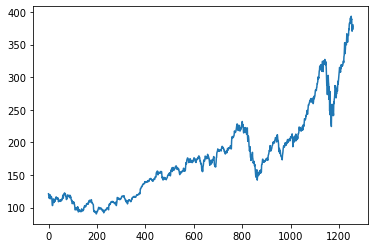

In [75]:
plt.plot(df1)

In [76]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [77]:
df1.shape

(1258, 1)

In [78]:
training_size = int(len(df1) * 0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [79]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [80]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [81]:
print(X_train)

[[0.10214788 0.09271174 0.08017421 ... 0.06149988 0.0517668  0.05605596]
 [0.09271174 0.08017421 0.08268171 ... 0.0517668  0.05605596 0.05572602]
 [0.08017421 0.08268171 0.08179089 ... 0.05605596 0.05572602 0.06027913]
 ...
 [0.31848626 0.32960507 0.33485103 ... 0.43171995 0.41466231 0.42551717]
 [0.32960507 0.33485103 0.33973407 ... 0.41466231 0.42551717 0.4299383 ]
 [0.33485103 0.33973407 0.34194464 ... 0.42551717 0.4299383  0.43680095]]


In [82]:
print(X_test.shape)

(340, 100)


In [83]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [84]:
model = Sequential()

In [85]:
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 400ms/step - loss: 0.0120 - val_loss: 0.0586
Epoch 2/100
12/12 [==============================] - 3s 289ms/step - loss: 0.0021 - val_loss: 0.0068
Epoch 3/100
12/12 [==============================] - 3s 291ms/step - loss: 7.4008e-04 - val_loss: 0.0031
Epoch 4/100
12/12 [==============================] - 4s 299ms/step - loss: 5.0669e-04 - val_loss: 0.0040
Epoch 5/100
12/12 [==============================] - 4s 302ms/step - loss: 4.3175e-04 - val_loss: 0.0039
Epoch 6/100
12/12 [==============================] - 4s 300ms/step - loss: 4.0285e-04 - val_loss: 0.0037
Epoch 7/100
12/12 [==============================] - 4s 302ms/step - loss: 3.9310e-04 - val_loss: 0.0038
Epoch 8/100
12/12 [==============================] - 4s 302ms/step - loss: 3.8669e-04 - val_loss: 0.0044
Epoch 9/100
12/12 [==============================] - 4s 298ms/step - loss: 4.1270e-04 - val_loss: 0.0044
Epoch 10/100
12/12 [==============================] - 4s 304ms/

12/12 [==============================] - 4s 292ms/step - loss: 2.1500e-04 - val_loss: 0.0012
Epoch 79/100
12/12 [==============================] - 4s 301ms/step - loss: 1.8496e-04 - val_loss: 0.0014
Epoch 80/100
12/12 [==============================] - 4s 304ms/step - loss: 1.8011e-04 - val_loss: 0.0012
Epoch 81/100
12/12 [==============================] - 4s 300ms/step - loss: 1.8069e-04 - val_loss: 0.0034
Epoch 82/100
12/12 [==============================] - 4s 300ms/step - loss: 2.2842e-04 - val_loss: 0.0011
Epoch 83/100
12/12 [==============================] - 4s 303ms/step - loss: 1.9005e-04 - val_loss: 0.0017
Epoch 84/100
12/12 [==============================] - 4s 299ms/step - loss: 1.9171e-04 - val_loss: 0.0019
Epoch 85/100
12/12 [==============================] - 4s 302ms/step - loss: 1.7057e-04 - val_loss: 0.0012
Epoch 86/100
12/12 [==============================] - 4s 301ms/step - loss: 1.6859e-04 - val_loss: 0.0022
Epoch 87/100
12/12 [==============================] - 4s 29

In [88]:
tf.__version__

'2.2.0'

In [89]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [90]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [91]:
math.sqrt(mean_squared_error(y_train, train_predict))

149.38333950693024

In [92]:
math.sqrt(mean_squared_error(ytest, test_predict))

258.39057070355005

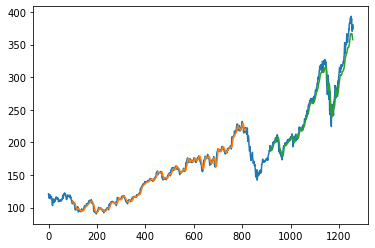

In [93]:
## Plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [94]:
len(test_data)

441

In [95]:
x_input = test_data[len(test_data)-100:].reshape(1,-1)
print(x_input.shape)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()


(1, 100)


In [96]:
# demonstrate prediction for next 5 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    if (len(temp_input)>100):
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        i = i+1
    
    print(lst_output)

[0.87431717]
[]
1 day input [0.64337326 0.6106767  0.52093438 0.61905705 0.50107229 0.53621037
 0.51578739 0.50955162 0.45827972 0.44221188 0.51648025 0.51199314
 0.55462074 0.51931769 0.5426441  0.54092844 0.49678313 0.51004652
 0.49843281 0.56791712 0.5578871  0.57979478 0.58612953 0.60348411
 0.64901514 0.64037085 0.64782738 0.63499291 0.61562572 0.58738329
 0.61288726 0.60935696 0.6355538  0.63621367 0.62106965 0.6512587
 0.67128576 0.65567983 0.66917417 0.68369131 0.69382032 0.7040813
 0.72516414 0.74126497 0.72938731 0.71698175 0.72321753 0.71717972
 0.7411     0.73509519 0.75518823 0.74733577 0.75406645 0.74693985
 0.75149296 0.75195486 0.75093207 0.76383252 0.76874856 0.7746214
 0.76538322 0.79567125 0.80213798 0.83688013 0.86607938 0.81018839
 0.81975651 0.83358078 0.86357188 0.86195519 0.8624171  0.85578541
 0.88597446 0.91124748 0.88990069 0.90567158 0.86868587 0.89557557
 0.90553961 0.90326306 0.90326306 0.93539873 0.93157148 0.96020984
 0.96562077 0.96783134 0.96199149 0.9

7 day output [[0.7895326]]
[[0.8675408959388733], [0.8557192087173462], [0.8413683772087097], [0.8266005516052246], [0.812702476978302], [0.8002839684486389], [0.7895326018333435]]
8 day input [0.50955162 0.45827972 0.44221188 0.51648025 0.51199314 0.55462074
 0.51931769 0.5426441  0.54092844 0.49678313 0.51004652 0.49843281
 0.56791712 0.5578871  0.57979478 0.58612953 0.60348411 0.64901514
 0.64037085 0.64782738 0.63499291 0.61562572 0.58738329 0.61288726
 0.60935696 0.6355538  0.63621367 0.62106965 0.6512587  0.67128576
 0.65567983 0.66917417 0.68369131 0.69382032 0.7040813  0.72516414
 0.74126497 0.72938731 0.71698175 0.72321753 0.71717972 0.7411
 0.73509519 0.75518823 0.74733577 0.75406645 0.74693985 0.75149296
 0.75195486 0.75093207 0.76383252 0.76874856 0.7746214  0.76538322
 0.79567125 0.80213798 0.83688013 0.86607938 0.81018839 0.81975651
 0.83358078 0.86357188 0.86195519 0.8624171  0.85578541 0.88597446
 0.91124748 0.88990069 0.90567158 0.86868587 0.89557557 0.90553961
 0.9032

 0.76118803 0.75681531 0.75311106 0.74987864]
15 day output [[0.74693877]]
[[0.8675408959388733], [0.8557192087173462], [0.8413683772087097], [0.8266005516052246], [0.812702476978302], [0.8002839684486389], [0.7895326018333435], [0.7804109454154968], [0.7727757692337036], [0.7664374113082886], [0.7611880302429199], [0.7568153142929077], [0.7531110644340515], [0.7498786449432373], [0.7469387650489807]]
16 day input [0.54092844 0.49678313 0.51004652 0.49843281 0.56791712 0.5578871
 0.57979478 0.58612953 0.60348411 0.64901514 0.64037085 0.64782738
 0.63499291 0.61562572 0.58738329 0.61288726 0.60935696 0.6355538
 0.63621367 0.62106965 0.6512587  0.67128576 0.65567983 0.66917417
 0.68369131 0.69382032 0.7040813  0.72516414 0.74126497 0.72938731
 0.71698175 0.72321753 0.71717972 0.7411     0.73509519 0.75518823
 0.74733577 0.75406645 0.74693985 0.75149296 0.75195486 0.75093207
 0.76383252 0.76874856 0.7746214  0.76538322 0.79567125 0.80213798
 0.83688013 0.86607938 0.81018839 0.81975651 0.8

21 day output [[0.72867715]]
[[0.8675408959388733], [0.8557192087173462], [0.8413683772087097], [0.8266005516052246], [0.812702476978302], [0.8002839684486389], [0.7895326018333435], [0.7804109454154968], [0.7727757692337036], [0.7664374113082886], [0.7611880302429199], [0.7568153142929077], [0.7531110644340515], [0.7498786449432373], [0.7469387650489807], [0.7441356778144836], [0.7413406372070312], [0.7384539246559143], [0.7354052066802979], [0.732151985168457], [0.7286771535873413]]
22 day input [0.57979478 0.58612953 0.60348411 0.64901514 0.64037085 0.64782738
 0.63499291 0.61562572 0.58738329 0.61288726 0.60935696 0.6355538
 0.63621367 0.62106965 0.6512587  0.67128576 0.65567983 0.66917417
 0.68369131 0.69382032 0.7040813  0.72516414 0.74126497 0.72938731
 0.71698175 0.72321753 0.71717972 0.7411     0.73509519 0.75518823
 0.74733577 0.75406645 0.74693985 0.75149296 0.75195486 0.75093207
 0.76383252 0.76874856 0.7746214  0.76538322 0.79567125 0.80213798
 0.83688013 0.86607938 0.8101

26 day output [[0.7086427]]
[[0.8675408959388733], [0.8557192087173462], [0.8413683772087097], [0.8266005516052246], [0.812702476978302], [0.8002839684486389], [0.7895326018333435], [0.7804109454154968], [0.7727757692337036], [0.7664374113082886], [0.7611880302429199], [0.7568153142929077], [0.7531110644340515], [0.7498786449432373], [0.7469387650489807], [0.7441356778144836], [0.7413406372070312], [0.7384539246559143], [0.7354052066802979], [0.732151985168457], [0.7286771535873413], [0.7249850034713745], [0.7210972905158997], [0.7170484662055969], [0.7128812670707703], [0.7086427211761475]]
27 day input [0.64782738 0.63499291 0.61562572 0.58738329 0.61288726 0.60935696
 0.6355538  0.63621367 0.62106965 0.6512587  0.67128576 0.65567983
 0.66917417 0.68369131 0.69382032 0.7040813  0.72516414 0.74126497
 0.72938731 0.71698175 0.72321753 0.71717972 0.7411     0.73509519
 0.75518823 0.74733577 0.75406645 0.74693985 0.75149296 0.75195486
 0.75093207 0.76383252 0.76874856 0.7746214  0.765383

In [97]:
day_new = np.arange(1,101)
day_pred = np.arange(101, 131)


In [98]:
df3=df1.tolist()
df3.extend(lst_output)
len(df1)

1258

In [99]:
print(scaler.inverse_transform(lst_output))

[[353.28297015]
 [349.69993497]
 [345.35034145]
 [340.87436119]
 [336.66199375]
 [332.898068  ]
 [329.63943629]
 [326.87475345]
 [324.5606079 ]
 [322.63951499]
 [321.04848009]
 [319.72315361]
 [318.60043252]
 [317.6207185 ]
 [316.7296703 ]
 [315.88008259]
 [315.03293373]
 [314.15800002]
 [313.23396409]
 [312.24794518]
 [311.19475848]
 [310.0757047 ]
 [308.89737778]
 [307.67021962]
 [306.40718324]
 [305.12252236]
 [303.83074365]
 [302.5456492 ]
 [301.279632  ]]


ValueError: x and y must have same first dimension, but have shapes (100,) and (101, 1)

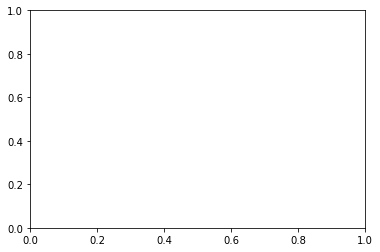

In [100]:
plt.plot(day_new, scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))